### 영화 리뷰 감정 분석

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext.legacy import data, datasets

In [ ]:
BATCH_SIZE = 64
lr = 0.001
EPOCHS = 40
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda' if USE_CUDA else 'cpu')

In [ ]:
TEXT = data.Field(sequential=True, batch_first=True, lower=True)
LABEL = data.Field(sequential=False, batch_first=True)

In [ ]:
trainset, testset = datasets.IMDB.splits(TEXT, LABEL)

downloading aclImdb_v1.tar.gz


100%|██████████| 84.1M/84.1M [00:05<00:00, 14.9MB/s]


In [ ]:
for i in trainset:
    print(i.text)
    break

['of', 'course', 'if', 'you', 'are', 'reading', 'my', 'review', 'you', 'have', 'seen', 'this', 'film', 'already.', "'raja", "babu'", 'is', 'one', 'of', 'my', 'most', 'favorite', 'characters.', 'i', 'just', 'love', 'the', 'concept', 'of', 'a', 'spoiled', 'brat', 'with', 'a', '24*7', 'servant', 'on', 'his', 'motorcycle.', 'watch', 'movies', 'and', 'emulate', 'characters', 'etc', 'etc.', 'i', 'love', 'the', 'scene', 'when', 'a', 'stone', 'cracks', 'in', 'kader', 'khans', 'mouth', 'while', 'eating.', 'also', 'where', 'shakti', 'kapoor', 'narrates', 'a', 'corny', 'story', 'of', 'raja', "babu's", 'affairs', 'on', 'a', 'dinner', 'table', 'and', 'govinda', 'wearing', "'dharam-veer'", 'uniform', 'makes', 'sentimental', 'remarks.', 'thats', 'my', 'favorite', 'scene', 'of', 'the', 'film.', "'achcha", 'pitaji', 'to', 'main', 'chalta', "hoon'", 'scene', 'is', 'just', 'chemistry', 'between', 'two', 'great', 'indian', 'actors', 'doing', 'a', 'comical', 'scene', 'with', 'no', 'dialogs.', 'its', 'brill

In [ ]:
TEXT.build_vocab(trainset, min_freq=5)  # 최소 5번 이상 등장한 단어만을 사전에 담겠다
LABEL.build_vocab(trainset)

In [ ]:
trainset, valset = trainset.split(split_ratio=0.8)
train_iter, val_iter, test_iter = data.BucketIterator.splits(
    (trainset, valset, testset),
    batch_size=BATCH_SIZE,
    shuffle=True, repeat=False
)

In [ ]:
vocab_size = len(TEXT.vocab)
n_classes = 2

In [ ]:
print(f"[학습셋]: {len(trainset)}, [검증셋]: {len(valset)}, [테스트셋]: {len(testset)}, [단어수]: {vocab_size}, [클래스]: {n_classes}")

[학습셋]: 20000, [검증셋]: 5000, [테스트셋]: 25000, [단어수]: 46159, [클래스]: 2


In [ ]:
class BasicGRU(nn.Module):
    def __init__(self, n_layers, hidden_dim, n_vocab, embed_dim, n_classes, dropout_p=0.2):
        super(BasicGRU, self).__init__()
        print("Building Basic GRU model...")
        
        self.n_layers = n_layers    # 은닉벡터들의 '층'
        self.embed = nn.Embedding(n_vocab, embed_dim)
        self.hidden_dim = hidden_dim    # 은닉벡터의 차원값
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(embed_dim, self.hidden_dim,   # 문장의 뒷부분에 다다를수록 앞부분의 정보가 소실되는 어려움을 겪는 RNN을 보완한 'GRU'
                          num_layers=self.n_layers,
                          batch_first=True)
        self.out = nn.Linear(self.hidden_dim, n_classes)

    def forward(self, x):
        x = self.embed(x)   # 임베딩으로 벡터 배열 생성
        h_0 = self._init_state(batch_size=x.size(0))    # 첫 번째 은닉벡터 정의 
        x, _ = self.gru(x, h_0)
        h_t = x[:,-1,:]     # (batch_size, 1, hidden_dim) 모양의 텐서 추출
        self.dropout(h_t)   
        logit = self.out(h_t)
        return logit

    def _init_state(self, batch_size=1):    #???????????????????????????????????
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()

In [ ]:
def train(model, optimizer, train_iter):
    model.train()
    for b, batch in enumerate(train_iter):
        x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
        y.data.sub_(1)  # label을 (1,2) -> (0,1)로 1씩 빼주어 바꾼다
        
        optimizer.zero_grad()
        logit = model(x)
        loss = F.cross_entropy(logit, y)
        loss.backward()
        optimizer.step()

In [ ]:
def evaluate(model, val_iter):
    model.eval()
    corrects, total_loss = 0, 0
    for batch in val_iter:
        x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
        y.data.sub_(1)
        logit = model(x)
        loss = F.cross_entropy(logit, y, reduction='sum')
        total_loss += loss.item()
        corrects += (logit.max(1)[1].view(y.size()).data == y.data).sum()
    
    size = len(val_iter.dataset)
    avg_loss = total_loss / size
    avg_accuracy = 100.0 * corrects / size
    return avg_loss, avg_accuracy

In [ ]:
model = BasicGRU(1, 256, vocab_size, 128, n_classes, 0.5).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Building Basic GRU model...


In [ ]:
best_val_loss = None
for e in range(1, EPOCHS+1):
    train(model, optimizer, train_iter)
    val_loss, val_accuracy = evaluate(model, val_iter)
    print(f"[이폭: {e}] 검증 오차:{val_loss:5.2f} \| 검증 정확도:{val_accuracy:5.2f}")

    if not best_val_loss or val_loss < best_val_loss:
        if not os.path.isdir("snapshot"):
            os.makedirs("snapshot")
        torch.save(model.state_dict(), './snapshot/txtclassification.pt')   # val_loss가 가장 작은 모델 저장
        best_val_loss = val_loss

[이폭: 1] 검증 오차: 0.69 \| 검증 정확도:49.98
[이폭: 2] 검증 오차: 0.69 \| 검증 정확도:50.88
[이폭: 3] 검증 오차: 0.69 \| 검증 정확도:52.54
[이폭: 4] 검증 오차: 0.69 \| 검증 정확도:53.34
[이폭: 5] 검증 오차: 0.48 \| 검증 정확도:77.54
[이폭: 6] 검증 오차: 0.37 \| 검증 정확도:83.82
[이폭: 7] 검증 오차: 0.36 \| 검증 정확도:85.42
[이폭: 8] 검증 오차: 0.42 \| 검증 정확도:85.04
[이폭: 9] 검증 오차: 0.42 \| 검증 정확도:85.08
[이폭: 10] 검증 오차: 0.45 \| 검증 정확도:85.38
[이폭: 11] 검증 오차: 0.43 \| 검증 정확도:85.10
[이폭: 12] 검증 오차: 0.49 \| 검증 정확도:84.60
[이폭: 13] 검증 오차: 0.51 \| 검증 정확도:85.02
[이폭: 14] 검증 오차: 0.55 \| 검증 정확도:85.16
[이폭: 15] 검증 오차: 0.55 \| 검증 정확도:85.22
[이폭: 16] 검증 오차: 0.51 \| 검증 정확도:85.36
[이폭: 17] 검증 오차: 0.59 \| 검증 정확도:84.84
[이폭: 18] 검증 오차: 0.56 \| 검증 정확도:85.74


In [ ]:
model.load_state_dict(torch.load('./snapshot/txtclassification.pt'))    # 저장된 모델 불러오기
test_loss, test_acc = evaluate(model, test_iter)
print(f"테스트 오차: {test_loss:5.2f} \| 테스트 정확도: {test_acc:5.2f}")

NameError: ignored

### Seq2Seq 기계 번역

In [ ]:
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt

In [ ]:
vocab_size = 256

In [ ]:
x_ = list(map(ord, "hello"))
y_ = list(map(ord, "hola"))
x = torch.LongTensor(x_)
y = torch.LongTensor(y_)

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(Seq2Seq, self).__init__()
        self.n_layers = 1
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.encoder = nn.GRU(hidden_size, hidden_size)
        self.decoder = nn.GRU(hidden_size, hidden_size)
        self.project = nn.Linear(hidden_size, vocab_size)

    def forward(self, inputs, targets):
        initial_state = self._init_state()
        embedding = self.embedding(inputs).unsqueeze(1)
        encoder_output, encoder_state = self.encoder(embedding, initial_state)

        decoder_state = encoder_state
        decoder_input = torch.LongTensor([0])

        outputs = []
        for i in range(targets.size()[0]):
            decoder_input = self.embedding(decoder_input).unsqueeze(1)
            decoder_output, decoder_state = self.decoder(decoder_input, decoder_state)

            projection = self.project(decoder_output)
            outputs.append(projection)

            decoder_input = torch.LongTensor([targets[i]])
        outputs = torch.stack(outputs).squeeze()
        return outputs
    
    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_size).zero_()

In [ ]:
seq2seq = Seq2Seq(vocab_size, 16)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=1e-3)

In [ ]:
log = []
for i in range(1000):
    prediction = seq2seq(x, y)
    loss = criterion(prediction, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_val = loss.data
    log.append(loss_val)
    if i % 100 == 0:
        print(f"\n 반복:{i} 오차:{loss_val.item()}")
        _, top1 = prediction.data.topk(1, 1)
        print([chr(c) for c in top1.squeeze().numpy().tolist()])


 반복:0 오차:5.518559455871582
['\x92', 'è', '\x92', '\x92']

 반복:100 오차:1.9480890035629272
['h', 'l', 'l', 'a']

 반복:200 오차:0.7009897828102112
['h', 'o', 'l', 'a']

 반복:300 오차:0.4052084684371948
['h', 'o', 'l', 'a']

 반복:400 오차:0.2181721031665802
['h', 'o', 'l', 'a']

 반복:500 오차:0.14309045672416687
['h', 'o', 'l', 'a']

 반복:600 오차:0.10180743038654327
['h', 'o', 'l', 'a']

 반복:700 오차:0.07587451487779617
['h', 'o', 'l', 'a']

 반복:800 오차:0.058933075517416
['h', 'o', 'l', 'a']

 반복:900 오차:0.04736802726984024
['h', 'o', 'l', 'a']


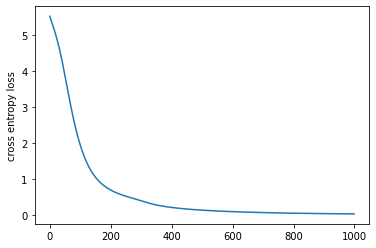

In [ ]:
plt.plot(log)
plt.ylabel("cross entropy loss")
plt.show()